## Expression models results analysis

In [1]:
from scipy.stats import binomtest
import os
import pickle
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

/pool01/conda/envs/enrollhd/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [15]:
lookuptab = pl.read_csv("/pool01/databases/biomart/hsapiens_ensembl_table.tsv", separator="\t")

os.chdir('/pool01/projects/abante_lab/')

rna_results_dir = "genomic_llms/multimodal_prediction/"
gen_results_dir = "ao_prediction_enrollhd_2024/ml_results/classification/v2/"
data_dir = "ao_prediction_enrollhd_2024/features/"
borzoi_dir = "genomic_llms/borzoi/proc_results/expression_vectors/"

putamen_path = borzoi_dir + "putamen/"
caudate_path = borzoi_dir + "caudate/"

# Read metrics tables
rna_metrics = pd.read_csv(f"{rna_results_dir}xgboost_metrics_summary.txt", sep="\t")
gen_metrics = pd.read_csv(f"{gen_results_dir}xgboost_metrics_summary.txt", sep="\t")

# Create column for dataset
rna_metrics['Dataset'] = rna_metrics['Model'].apply(lambda x: x.split('_')[0])
gen_metrics['Dataset'] = gen_metrics['Model'].apply(lambda x: x.split('_')[0])

# Column for seed
rna_metrics['Seed'] = rna_metrics['Model'].apply(lambda x: x.split('_')[-1])
gen_metrics['Seed'] = gen_metrics['Model'].apply(lambda x: x.split('_')[-1])

# Concatenate metrics
metrics = pd.concat([rna_metrics, gen_metrics[gen_metrics['Dataset']=='b1']], ignore_index=True)

In [4]:
np.median(rna_metrics.loc[rna_metrics['Dataset'] == 'expression', 'Accuracy'])

0.24183169127667536

In [38]:
rna_metrics.loc[rna_metrics[rna_metrics['Dataset'] == 'expression']['Accuracy'].idxmax()]

Model                      expression_ES_xgboost_29
Depth                                             1
Learning Rate                                 0.001
Accuracy                                   0.255982
Train Balanced Accuracy                    0.255374
Precision                                  0.202179
Recall                                     0.261445
F1-Score                                   0.198766
Support                                      1813.0
Recall_0                                        0.0
Recall_1                                   0.397878
Recall_2                                   0.210959
Recall_3                                   0.026087
Recall_4                                   0.644986
Dataset                                  expression
Seed                                             29
Name: 20, dtype: object

In [25]:
rna_metrics.loc[rna_metrics[rna_metrics['Dataset'] == 'multimodal']['Accuracy'].idxmax()]

Model                      multimodal_ES_xgboost_45
Depth                                             2
Learning Rate                                   0.1
Accuracy                                   0.268315
Train Balanced Accuracy                      0.4653
Precision                                  0.262559
Recall                                     0.267512
F1-Score                                   0.258214
Support                                      1813.0
Recall_0                                       0.24
Recall_1                                   0.313625
Recall_2                                   0.275362
Recall_3                                   0.106952
Recall_4                                   0.405634
Dataset                                  multimodal
Seed                                             45
Name: 88, dtype: object

In [30]:
metrics.loc[metrics[metrics['Dataset'] == 'b1']['Accuracy'].idxmax()]

Model                      b1_ES_xgboost_45
Depth                                     1
Learning Rate                          0.01
Accuracy                           0.270713
Train Balanced Accuracy            0.348732
Precision                          0.256479
Recall                             0.268616
F1-Score                           0.251444
Support                              1813.0
Recall_0                           0.271429
Recall_1                           0.287918
Recall_2                           0.301449
Recall_3                            0.05615
Recall_4                            0.43662
Dataset                                  b1
Seed                                     45
Name: 137, dtype: object

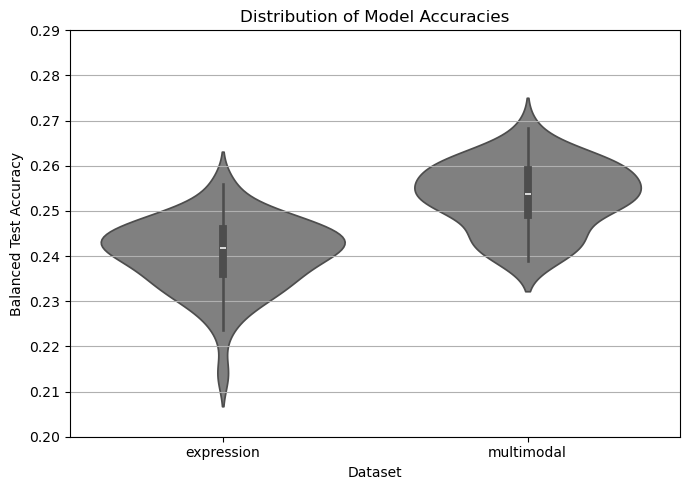

In [34]:
# Violin plot of accuracies
plt.figure(figsize=(7, 5))
sns.violinplot(x="Dataset", y='Accuracy', data=rna_metrics, color='grey'
)
plt.ylabel('Balanced Test Accuracy')
plt.title('Distribution of Model Accuracies')
plt.ylim(0.20, 0.29)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(f"{rna_results_dir}figures/rna_accuracy_violin_plot.pdf", dpi=300)  
plt.show()

In [23]:
# Significance tests of accuracy improvement

x = metrics[metrics['Dataset'] == 'expression']['Accuracy'].to_list()
k = sum([xi > 0.2 for xi in x])
n = len(x)

result = binomtest(k, n, p=0.5, alternative='greater')
print(result.pvalue)

8.881784197001252e-16


More than half the models trained with just CAG and RNA coverage prediction features have balanced test accuracies bigger than 0.2.

In [29]:
from scipy.stats import wilcoxon

# Make sure the data is aligned by index or sample ID
paired_data = rna_metrics.pivot(index='Seed', columns='Dataset', values='Accuracy')  # adjust if needed

# Remove any rows with NaN values
paired_data = paired_data.dropna()

stat, p = wilcoxon(paired_data["expression"], paired_data["multimodal"])
print(f"Wilcoxon test statistic: {stat}, p-value: {p}")

Wilcoxon test statistic: 28.0, p-value: 5.268674385661143e-12


Models trained with RNA coverage prediction features are statistically diferent between using genotype features or not.

In [7]:
from scipy.stats import wilcoxon

# Comparison between genotype xgboosts and multimodal xgboosts
genvsmulti = metrics[metrics['Dataset'].isin(['b1', 'multimodal'])].pivot(index='Seed', columns='Dataset', values='Accuracy').dropna()

stat, p = wilcoxon(genvsmulti["multimodal"], genvsmulti["b1"])
print(f"Wilcoxon test statistic: {stat}, p-value: {p}")

Wilcoxon test statistic: 481.0, p-value: 0.19434695290547666


### RNA XGBoost

In [33]:
# Read feature importance table
total_importance = pd.read_csv(f"{rna_results_dir}expression_xgboost_total_importance.txt", sep="\t")
total_importance.head(10)

,Gene,Tissue,Score
0,CAG,all,918.222894
1,PPP2R2C,putamen,283.408594
2,TLX1,caudate,202.673745
3,EHF,putamen,193.327005
4,MSGN1,putamen,167.260584
5,CAPN12,caudate,158.866669
6,ENSG00000257543,caudate,128.301629
7,TFB2M,caudate,125.001731
8,LINC00543,putamen,124.886833
9,ZNF534,putamen,123.071986


In [12]:
print(*total_importance['Gene'].to_list(), sep=' ')

CAG PPP2R2C TLX1 EHF MSGN1 CAPN12 ENSG00000257543 TFB2M LINC00543 ZNF548 ZNF534 IFIT5 ENSG00000268970 LINC00404 CXCR4 ZNF230-DT PPIP5K1 PHF10 ENSG00000260271 TAS1R1 ZSCAN2 DMRT1 ROCR CD207 ZNF235 ERLIN2 ZSCAN31 ZBTB10 MGST1 NRG1 ZNF8-DT CFAP298 MAPT-IT1 ZNF891 ENSG00000224076 PSMD7 ZNF135 MYF6 ARHGEF11 SLC13A5 ENSG00000269296 DUSP15 NUDT21 SNCA-AS1 E2F7 RHBDD3 MED23 CASC11 DBT MT1B SOX14 ENSG00000272449 HES3 DMBX1 ENSG00000260022 CSRP3 DIO2 ENSG00000258891 CUL2 ZNF14 WFS1 UBTD1 C6orf120 TRIM55 TSTD1 CLEC4A ELF5 RANBP17 NME2 MAP1LC3A ENSG00000249684 PIGB ENSG00000180458 ZNF85 LINC01726 ENSG00000267606 ZKSCAN7-AS1 TRIM16L ZNF512 RBAK AHR DDN EID2B GRIK1 CTSL SMAD5 FOLR2 ENSG00000225102 ENSG00000248664 NCCRP1 ZSCAN12 POLR2I ZNF215 ENSG00000226172 ENSG00000262899 TTC5 FAM210B DMRT3 PPARG UTS2B TULP3 MIR3659HG ENSG00000222043 ZNF677 SPIRE2 ANAPC4 KLF17 SOX21-AS1 ZIM3 SELENOW TBX19 PANTR1 C1orf53 GRIA2 MGARP ENSG00000275236 DMRT2 LINC02200 ENSG00000258670 ZDHHC8 ZNF701 SOX6 FOXA3 ZNF343 ENSG

In [13]:
# Load model's feature matrix header

# Load expression vectors
putamen_files = [f for f in os.listdir(putamen_path) if f.endswith(".txt.gz")]
expression_vectors_putamen = [pl.read_csv(os.path.join(putamen_path, f), separator="\t") for f in putamen_files]

# Keep sample column only from the first dataframe
base = expression_vectors_putamen[0]
others = [df.drop("sample") for df in expression_vectors_putamen[1:]]

# Concatenate all horizontally
expression_vectors_putamen = pl.concat([base] + others, how="horizontal")

caudate_files = [f for f in os.listdir(caudate_path) if f.endswith(".txt.gz")]
expression_vectors_caudate = [pl.read_csv(os.path.join(caudate_path, f), separator="\t") for f in caudate_files]

# Keep sample column only from the first dataframe
base = expression_vectors_caudate[0]
others = [df.drop("sample") for df in expression_vectors_caudate[1:]]

# Concatenate all horizontally
expression_vectors_caudate = pl.concat([base] + others, how="horizontal")

# List of header lists (first putamen, second caudate)
headers_ensmbl = [expression_vectors_putamen.drop("sample").columns, expression_vectors_caudate.drop("sample").columns, expression_vectors_putamen.drop("sample").columns + expression_vectors_caudate.drop("sample").columns]

# Change gene name format to symbol, leve ensembl_gene_id in null symbol cases
headers = []
for header_ensmbl in headers_ensmbl:
    header = (
        pl.DataFrame({"ensembl_gene_id": header_ensmbl})
        .join(lookuptab, on="ensembl_gene_id", how="left")
        .with_columns(
            pl.coalesce(["external_gene_name", "ensembl_gene_id"]).alias("header")
        )
        .select("header")
        .to_series()
        .to_list()
    )
    headers.append(header)

# Add tissue to gene name
putamen_header = [col + "_putamen" for col in headers[0]]
caudate_header = [col + "_caudate" for col in headers[1]]
header_tissue_nosexcag =  putamen_header + caudate_header

# Add sex and CAG to header
header_tissue = ["Sex", "CAG"] + header_tissue_nosexcag
header = ["Sex", "CAG"] + headers[2]
print('Beginning of header with tissue: ', header_tissue[:5])
print('End of header with tissue: ', header_tissue[-5:])
print('Beginning of header without tissue: ', header[:5])
print('End of header without tissue: ', header[-5:])

Beginning of header with tissue:  ['Sex', 'CAG', 'MT1E_putamen', 'ENSG00000247324_putamen', 'ENSG00000261103_putamen']
End of header with tissue:  ['HSD17B1_caudate', 'RASD1_caudate', 'HAP1_caudate', 'MEOX1_caudate', 'GRIN2C_caudate']
Beginning of header without tissue:  ['Sex', 'CAG', 'MT1E', 'ENSG00000247324', 'ENSG00000261103']
End of header without tissue:  ['HSD17B1', 'RASD1', 'HAP1', 'MEOX1', 'GRIN2C']


#### Tree structure of depth 2 models

In [ ]:
# Load the model
def cag_as_root(seed, model_name, results_dir, header):

    # Load trees
    model_trees = f"{results_dir}{model_name}_trees.csv"
    trees = pd.read_csv(model_trees, sep="\t", index_col=0)

    # Filter root nodes (Node == "0")
    root_nodes = trees[trees['Node'] == 0]

    # Filter those that use feature 'f1'
    f1_root_nodes = root_nodes[root_nodes['Feature'] == 'f1']

    # How many boosters use f1 as the first split?
    num_f1_root_splits = f1_root_nodes.shape[0]

    # Proportion among all boosters
    frac = num_f1_root_splits / root_nodes.shape[0] * 100

    print(f"Number of boosters in seed {seed} using 'f1' as root split: {num_f1_root_splits}")
    print(f"Percentage of boosters using 'f1' as root split: {frac:.2f}%")

    return frac

In [ ]:
# Order by accuracy
metrics['Seed'] = metrics['Model'].apply(lambda x: x.split('_')[-1])
sorted_expression = metrics[metrics['Dataset'] == 'expression']
sorted_expression = sorted_expression.sort_values(by='Accuracy', ascending=False)

f1_frac = []

for seed in metrics[(metrics['Dataset'] == 'expression') & (metrics['Depth'] == 2)]['Seed']:

    model_name = f"expression_ES_xgboost_{seed}" 
    frac_i = cag_as_root(seed, model_name, rna_results_dir, header)
    f1_frac.append(frac_i)

print(f"Mean fraction of boosters using CAG as first feature: {np.mean(f1_frac):.2f}%")

Number of boosters in seed 15 using 'f1' as root split: 3305
Percentage of boosters using 'f1' as root split: 66.10%
Number of boosters in seed 16 using 'f1' as root split: 3413
Percentage of boosters using 'f1' as root split: 68.26%
Number of boosters in seed 20 using 'f1' as root split: 425
Percentage of boosters using 'f1' as root split: 57.05%
Number of boosters in seed 21 using 'f1' as root split: 3688
Percentage of boosters using 'f1' as root split: 73.76%
Number of boosters in seed 22 using 'f1' as root split: 3417
Percentage of boosters using 'f1' as root split: 68.34%
Number of boosters in seed 27 using 'f1' as root split: 429
Percentage of boosters using 'f1' as root split: 47.14%
Number of boosters in seed 30 using 'f1' as root split: 3552
Percentage of boosters using 'f1' as root split: 71.04%
Number of boosters in seed 33 using 'f1' as root split: 43
Percentage of boosters using 'f1' as root split: 50.59%
Number of boosters in seed 37 using 'f1' as root split: 445
Percenta

## Multimodal models

In [3]:
# Read feature importance table
multimodal_total_importance = pd.read_csv(f"{rna_results_dir}multimodal_xgboost_total_importance.txt", sep="\t")

In [4]:
multimodal_total_importance.head(100)

,Gene,Tissue,Score
0,CAG,any,891.233058
1,rs11293,any,877.401256
2,rs61997076,any,580.425837
3,rs141338757,any,532.455187
4,rs79727797,any,436.446159
...,...,...,...
95,CASC11,putamen,71.174657
96,ENSG00000258891,caudate,70.534697
97,rs62255892,any,70.391571
98,LINC02603,caudate,70.118517


In [7]:
sum_tissue_total_importance = multimodal_total_importance.groupby('Gene', as_index=False)['Score'].sum().sort_values(by='Score', ascending=False).reset_index(drop=True)
top_importances = sum_tissue_total_importance.head(100)
non_snp_top = top_importances[~top_importances['Gene'].str.startswith('rs')]
non_snp_top

,Gene,Score
0,CAG,891.233058
8,PPP2R2C,274.578088
10,TLX1,250.479734
14,EHF,192.109667
18,ZNF548,152.772989
19,MSGN1,150.492832
21,ENSG00000260271,146.621326
23,LINC00543,145.462267
26,CAPN12,131.162235
27,E2F7,127.656542


In [8]:
sum_tissue_total_importance[sum_tissue_total_importance['Gene']=='FBXW4']

,Gene,Score


#### Enrichment analysis of expression features

In [54]:
expression_features = multimodal_total_importance[~multimodal_total_importance['Gene'].str.startswith('rs')]
print(*expression_features['Gene'].to_list()[1:], sep=' ')

PPP2R2C TLX1 EHF ZNF548 MSGN1 LINC00543 ENSG00000260271 CAPN12 PPIP5K1 SELENOW ZNF534 DMBX1 TFB2M ENSG00000257543 ZSCAN2 MAPT-IT1 ENSG00000269296 ENSG00000229337 E2F7 SOX21 ENSG00000248664 LINC00404 MGST1 DIO2 ENSG00000224076 ERLIN2 CXCR4 DMRT2 PHF10 ZNF235 GRIK1 TAS1R1 PIGB UBTD1 ENSG00000268970 MCM9 ENSG00000253389 ZNF677 CUL2 CASC11 ENSG00000258891 LINC02603 IFIT5 ZBTB10 ENSG00000262899 SMAD5 NIM1K TTC5 KLF17 MYF6 HES3 NRG1 ZNF746 ZSCAN31 BSX ENSG00000272449 DMRT3 ZNF8-DT DHFR SYNGAP1-AS1 SOX14 ENSG00000230534 MED23 NME2 C6orf120 NUDT21 ZNF230-DT DMRT1 BHLHE22-AS1 ARHGEF11 ENSG00000282021 DTL SNHG21 E2F3 LINC00391 MT1B EPHX4 ZNF582 ZSCAN12 ENSG00000277587 RHBDD3 ENSG00000288075 ZNF397 ENSG00000278060 FKBPL ENSG00000262983 SNCA-AS1 ELMO3 MRPS17 ZFP42 H3-5 ZNF485 CCDC78 CHMP3 OSGEPL1-AS1 ENSG00000267606 SOX6 POU5F1 UTS2B ASB4 EID2B EGR4 ZNF227 ENSG00000271265 ADK TMEM251 ENSG00000269504 LINC03020 ENSG00000226172 NIPAL1 ENSG00000267886 DHH TSTD1 ZNF91 ZNF333 POU6F2 USP17L30 ZNF133-AS1 

In [55]:
# Load enrichment analysis performed through gProfiler
enriched_terms = pd.read_csv(f'{rna_results_dir}figures/gProfiler_hsapiens_6-2-2025_1-12-52 PM__intersections.csv')
enriched_terms

,source,term_name,term_id,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections
0,GO:MF,DNA-binding transcription factor activity,GO:0003700,1.214161e-162,161.915724,1448,1567,448,20196,"TLX1,EHF,ZNF548,MSGN1,ZNF534,DMBX1,ZSCAN2,E2F7..."
1,GO:MF,transcription regulator activity,GO:0140110,4.799472e-160,159.318807,1962,1567,521,20196,"TLX1,EHF,ZNF548,MSGN1,ZNF534,DMBX1,TFB2M,ZSCAN..."
2,GO:MF,"DNA-binding transcription factor activity, RNA...",GO:0000981,6.648804e-151,150.177256,1359,1567,420,20196,"TLX1,EHF,ZNF548,MSGN1,ZNF534,DMBX1,ZSCAN2,E2F7..."
3,GO:MF,RNA polymerase II transcription regulatory reg...,GO:0000977,1.566233e-146,145.805143,1386,1567,419,20196,"TLX1,EHF,ZNF548,MSGN1,ZNF534,DMBX1,ZSCAN2,E2F7..."
4,GO:MF,transcription cis-regulatory region binding,GO:0000976,9.961457e-142,141.001677,1483,1567,428,20196,"TLX1,EHF,ZNF548,MSGN1,ZNF534,DMBX1,ZSCAN2,E2F7..."


In [56]:
def compute_log10_odds_ratio(row):
    a = row['intersection_size']
    b = row['term_size'] - a
    c = row['query_size'] - a
    d = row['effective_domain_size'] - (a + b + c)

    # Apply continuity correction to avoid division by zero
    a += 1
    b += 1
    c += 1
    d += 1

    or_value = (a * d) / (b * c)
    return np.log10(or_value)

# Add a new column with log10(Odds Ratio)
enriched_terms['log10_odds_ratio'] = enriched_terms.apply(compute_log10_odds_ratio, axis=1)

# Optionally, sort and plot
top_terms = enriched_terms.sort_values('log10_odds_ratio', ascending=True).head(20)
top_terms

,source,term_name,term_id,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections,log10_odds_ratio
1,GO:MF,transcription regulator activity,GO:0140110,4.799472e-160,159.318807,1962,1567,521,20196,"TLX1,EHF,ZNF548,MSGN1,ZNF534,DMBX1,TFB2M,ZSCAN...",0.774009
4,GO:MF,transcription cis-regulatory region binding,GO:0000976,9.961457e-142,141.001677,1483,1567,428,20196,"TLX1,EHF,ZNF548,MSGN1,ZNF534,DMBX1,ZSCAN2,E2F7...",0.796784
3,GO:MF,RNA polymerase II transcription regulatory reg...,GO:0000977,1.566233e-146,145.805143,1386,1567,419,20196,"TLX1,EHF,ZNF548,MSGN1,ZNF534,DMBX1,ZSCAN2,E2F7...",0.824118
2,GO:MF,"DNA-binding transcription factor activity, RNA...",GO:0000981,6.648804e-151,150.177256,1359,1567,420,20196,"TLX1,EHF,ZNF548,MSGN1,ZNF534,DMBX1,ZSCAN2,E2F7...",0.838965
0,GO:MF,DNA-binding transcription factor activity,GO:0003700,1.214161e-162,161.915724,1448,1567,448,20196,"TLX1,EHF,ZNF548,MSGN1,ZNF534,DMBX1,ZSCAN2,E2F7...",0.848847


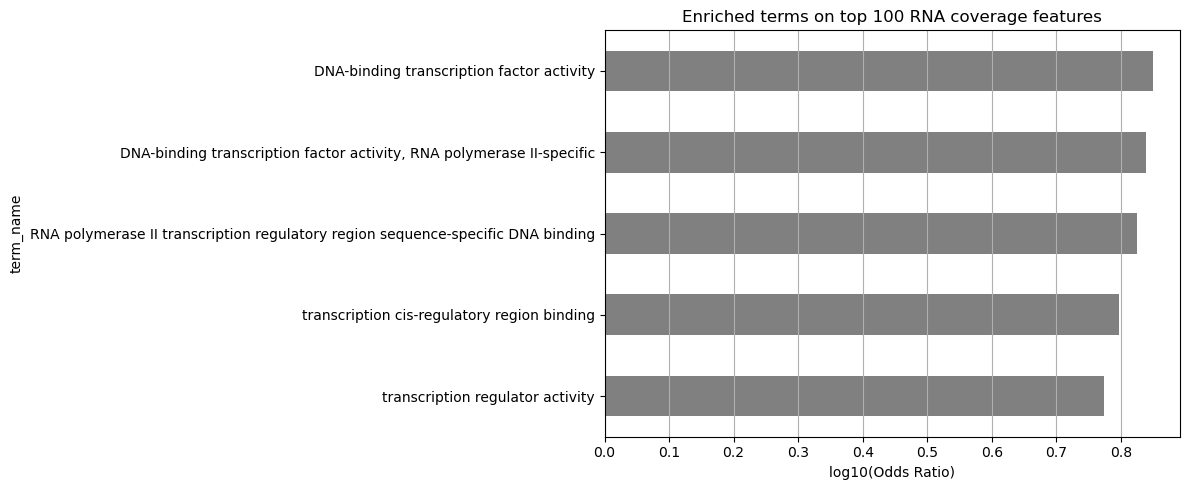

In [59]:
# Plot the horizontal bar plot
ax = top_terms.plot.barh(
    x='term_name', 
    y='log10_odds_ratio', 
    color='grey', 
    figsize=(12, 5)  # You can adjust height/width here
)

ax.set_xlabel('log10(Odds Ratio)')
ax.set_title('Enriched terms on top 100 RNA coverage features')
ax.grid(axis='x')
ax.legend().remove()
plt.tight_layout()
plt.savefig(f"{rna_results_dir}figures/go_enrichment_multimodal.pdf", dpi=300, bbox_inches='tight')
plt.show()

#### Tree structure of best model

In [26]:
# Load trees
seed = 45
model_trees = f"{rna_results_dir}multimodal_ES_xgboost_{seed}_trees.csv"
trees = pd.read_csv(model_trees, sep="\t", index_col=0)

def unscale_cag(cag):
    return cag * (55-40) + 40

# For multimodal xgboosts, concatenate to genotype header
with open(data_dir + "subsetting/header_feature_matrix_m3_filt_0.01.txt", "r") as file:
    header_genotype = file.readline().strip().split("\t")
header_genotype = header_genotype[1:]

# header_genotype = [col + "_any" for col in header_genotype]

header = header_genotype + headers[2]
header[-5:]

['HSD17B1', 'RASD1', 'HAP1', 'MEOX1', 'GRIN2C']

In [27]:
records = []

# Get all trees where root node is 'f1'
f1_roots = trees[(trees['Node'] == 0) & (trees['Feature'] == 'f1')]

for _, root in f1_roots.iterrows():
    tree_id = root['Tree']
    root_split = unscale_cag(float(root['Split']))

    # Get the IDs of the root's children (second-level nodes)
    second_nodes = trees[
        (trees['Tree'] == tree_id) &
        (trees['ID'].isin([root['Yes'], root['No'], root['Missing']])) &
        (trees['Feature'] != 'Leaf')  # Must be split nodes
    ]

    for _, second in second_nodes.iterrows():
        second_feature = header[int(second['Feature'][1:])]
        second_split = float(second['Split'])
        second_id = second['ID']

        # Get the children of this second-level node (leaves at depth 2)
        leaf_nodes = trees[
            (trees['Tree'] == tree_id) &
            (trees['ID'].isin([second['Yes'], second['No'], second['Missing']])) &
            (trees['Feature'] == 'Leaf')
        ]

        for _, leaf in leaf_nodes.iterrows():
            records.append({
                'Tree': tree_id,
                'RootSplit': root_split,
                'SecondNodeID': second_id,
                'SecondFeature': second_feature,
                'SecondSplit': second_split,
                'LeafNodeID': leaf['ID'],
                'Prediction': leaf['Gain']
            })

# Convert to DataFrame
secondary_split_summary = pd.DataFrame(records)
secondary_split_summary

,Tree,RootSplit,SecondNodeID,SecondFeature,SecondSplit,LeafNodeID,Prediction
0,0,46.0,0-1,rs112709638,2.000000,0-3,0.041241
1,0,46.0,0-1,rs112709638,2.000000,0-4,0.004165
2,0,46.0,0-2,rs116112884,-0.000010,0-5,-0.020930
3,0,46.0,0-2,rs116112884,-0.000010,0-6,0.094595
4,1,44.0,1-1,rs74731261,-0.000010,1-3,-0.013715
...,...,...,...,...,...,...,...
183,179,42.0,179-2,rs245105,-0.000010,179-6,-0.015116
184,180,43.0,180-1,RHBDD3,0.000003,180-3,-0.000531
185,180,43.0,180-1,RHBDD3,0.000003,180-4,0.025200
186,180,43.0,180-2,rs77757514,-0.000010,180-5,-0.007727


In [ ]:
# Filter rows to only obtain seconday features relative to expression features
secondary_split_summary = secondary_split_summary[~secondary_split_summary['SecondFeature'].str.startswith('rs')]
secondary_split_summary

,Tree,RootSplit,SecondNodeID,SecondFeature,SecondSplit,LeafNodeID,Prediction
6,1,44.0,1-2,FOXI2,-0.002524,1-5,0.003732
7,1,44.0,1-2,FOXI2,-0.002524,1-6,0.027419
26,7,45.0,7-2,NEUROG3,0.001610,7-5,0.012766
27,7,45.0,7-2,NEUROG3,0.001610,7-6,0.057605
38,11,44.0,11-2,ZNF80,0.000001,11-5,0.006088
39,11,44.0,11-2,ZNF80,0.000001,11-6,0.033101
54,16,44.0,16-2,ENSG00000258891,-0.017088,16-5,0.028230
55,16,44.0,16-2,ENSG00000258891,-0.017088,16-6,0.004366
56,17,45.0,17-1,ZNF525,-0.000294,17-3,0.018562
57,17,45.0,17-1,ZNF525,-0.000294,17-4,-0.011043


In [29]:
def rootcag_col_histogram(secondary_split_summary, top_genes):
    """
    Plot a heatmap where each column is a gene and the rows are different root CAG splits.
    The value in the cells corresponds to how many trees are using that gene as a 
    secondary split, having CAG at the root node with a particular split value.
    """
    filtered_df = secondary_split_summary[secondary_split_summary['SecondFeature'].isin(top_genes)]

    # Create pivot table: RootSplit as rows, Gene as columns
    pivot = pd.pivot_table(filtered_df, values='Tree', index='RootSplit', columns='SecondFeature', aggfunc='count', fill_value=0)

    # Histogram column: total counts per RootSplit (row-wise sum)
    pivot.insert(0, 'All', pivot.sum(axis=1))

    # Sort gene columns (excluding 'All') by lowest RootSplit they appear in
    def first_nonzero_index(col):
        return next((i for i, val in enumerate(col) if val > 0), float('inf'))

    gene_order = sorted([gene for gene in pivot.columns if gene != 'All'],
                        key=lambda gene: first_nonzero_index(pivot[gene].values))

    # Reinsert 'All' as the first column
    pivot = pivot[['All'] + gene_order]

    # Plot with matplotlib
    fig, ax = plt.subplots(figsize=(14, 8))
    im = ax.imshow(pivot.values, cmap='Blues')

    # Axis ticks and labels
    ax.set_xticks(np.arange(pivot.columns.shape[0]))
    ax.set_xticklabels(pivot.columns, rotation=45, ha="right")

    ax.set_yticks(np.arange(pivot.index.shape[0]))
    ax.set_yticklabels([int(r) for r in pivot.index])  # Ensure y-axis is integer labels

    # Annotate each cell with its value
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.iloc[i, j]
            if val > 0:
                ax.text(j, i, str(val), ha="center", va="center", color="black", fontsize=8)

    # Titles and labels
    ax.set_title("RootSplit vs Top 20 Genes Most Used in 2nd Split")
    ax.set_xlabel("Gene (and Total)")
    ax.set_ylabel("CAG RootSplit")

    fig.tight_layout()
    # plt.show()

    return fig, ax

(<Figure size 1400x800 with 1 Axes>,
 <Axes: title={'center': 'RootSplit vs Top 20 Genes Most Used in 2nd Split'}, xlabel='Gene (and Total)', ylabel='CAG RootSplit'>)

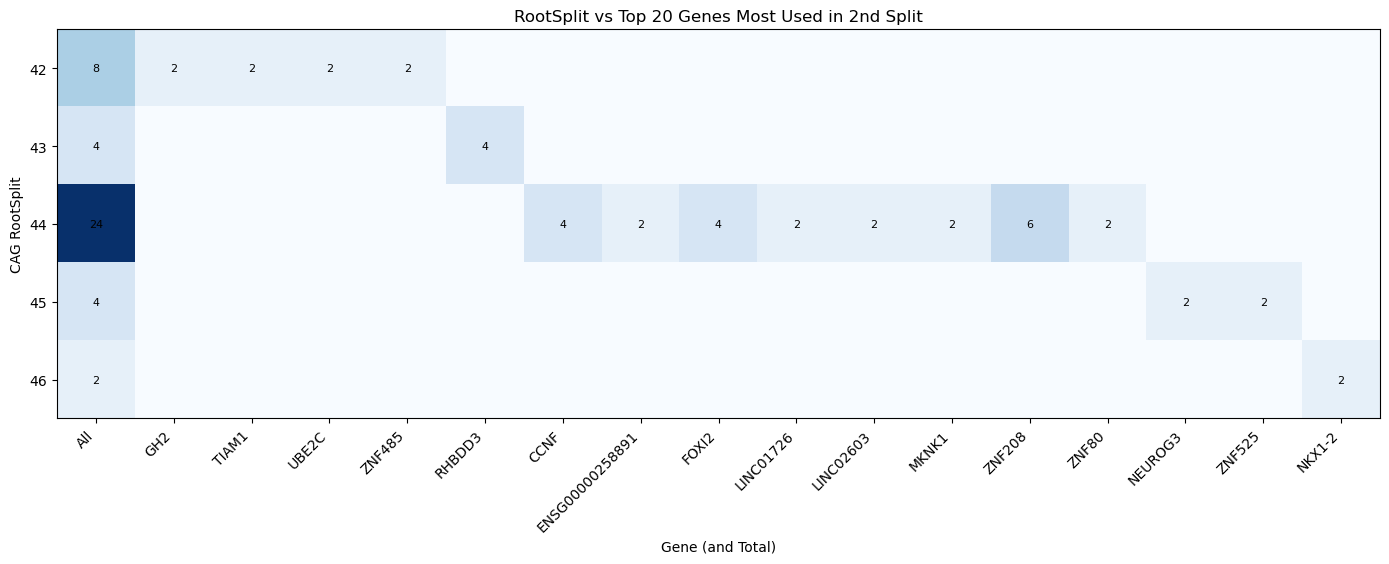

In [30]:
top_genes = secondary_split_summary['SecondFeature'].value_counts().head(20).index

rootcag_col_histogram(secondary_split_summary, top_genes)

#### For all models

In [52]:
len(valid_metrics)/len(rna_metrics[(rna_metrics["Dataset"] == "multimodal")])

0.4489795918367347

In [32]:
# Load metrics and filter
valid_metrics = rna_metrics[(rna_metrics["Depth"] == 2) &
                        (rna_metrics["Dataset"] == "multimodal")]

seeds = valid_metrics["Seed"].unique()

# Store all records
all_records = []

# Store proportion of f1 CAG trees
tree_props = []

# Iterate through all valid seeds
for seed in seeds:
    tree_file = f"{rna_results_dir}multimodal_ES_xgboost_{seed}_trees.csv"
    if not os.path.exists(tree_file):
        print(f"Missing trees for seed {seed}")
        continue
    
    trees = pd.read_csv(tree_file, sep="\t", index_col=0)
    f1_roots = trees[(trees['Node'] == 0) & (trees['Feature'] == 'f1')]

    n_trees = len(trees['Tree'].unique())
    n_f1cag_trees = len(f1_roots['Tree'].unique())
    tree_props.append({'Seed':seed, 'N_trees': n_trees, 'f1CAG_trees': n_f1cag_trees, 'proportion': round((n_f1cag_trees/n_trees*100), 3)})

    for _, root in f1_roots.iterrows():
        tree_id = root['Tree']
        root_split = unscale_cag(float(root['Split']))

        second_nodes = trees[
            (trees['Tree'] == tree_id) &
            (trees['ID'].isin([root['Yes'], root['No'], root['Missing']])) &
            (trees['Feature'] != 'Leaf')
        ]

        for _, second in second_nodes.iterrows():
            second_feature = header[int(second['Feature'][1:])]
            second_split = float(second['Split'])
            second_id = second['ID']

            leaf_nodes = trees[
                (trees['Tree'] == tree_id) &
                (trees['ID'].isin([second['Yes'], second['No'], second['Missing']])) &
                (trees['Feature'] == 'Leaf')
            ]

            for _, leaf in leaf_nodes.iterrows():
                all_records.append({
                    'Tree': tree_id,
                    'Seed': seed,
                    'RootSplit': root_split,
                    'SecondNodeID': second_id,
                    'SecondFeature': second_feature,
                    'SecondSplit': second_split,
                    'LeafNodeID': leaf['ID'],
                    'Prediction': leaf['Gain']    
                })

# Create aggregated DataFrame
secondary_split_summary = pd.DataFrame(all_records).drop_duplicates(subset=["SecondNodeID", "Seed"])

In [40]:
secondary_split_summary = secondary_split_summary[~secondary_split_summary['SecondFeature'].str.startswith('rs')]
secondary_split_summary = secondary_split_summary[~secondary_split_summary['SecondFeature'].str.startswith('ENSG')]
secondary_split_summary

,Tree,Seed,RootSplit,SecondNodeID,SecondFeature,SecondSplit,LeafNodeID,Prediction
2,0,12,46.0,0-2,CRBN,1.053856e-02,0-5,-0.002075
8,2,12,45.0,2-1,YY1,4.857034e-04,2-3,-0.001101
18,5,12,46.0,5-2,CRBN,1.053856e-02,5-5,-0.002066
24,7,12,45.0,7-1,YY1,4.857034e-04,7-3,-0.001095
34,10,12,46.0,10-2,CRBN,1.053856e-02,10-5,-0.002057
...,...,...,...,...,...,...,...,...
152902,4971,9,42.0,4971-2,ANKS4B,8.320919e-07,4971-5,-0.000037
152914,4980,9,47.0,4980-2,MT1B,-4.972707e-02,4980-5,0.000094
152926,4986,9,42.0,4986-2,EXOC3L1,-6.116034e-06,4986-5,-0.000164
152940,4995,9,47.0,4995-1,ZNF511,1.047883e-02,4995-3,0.000038


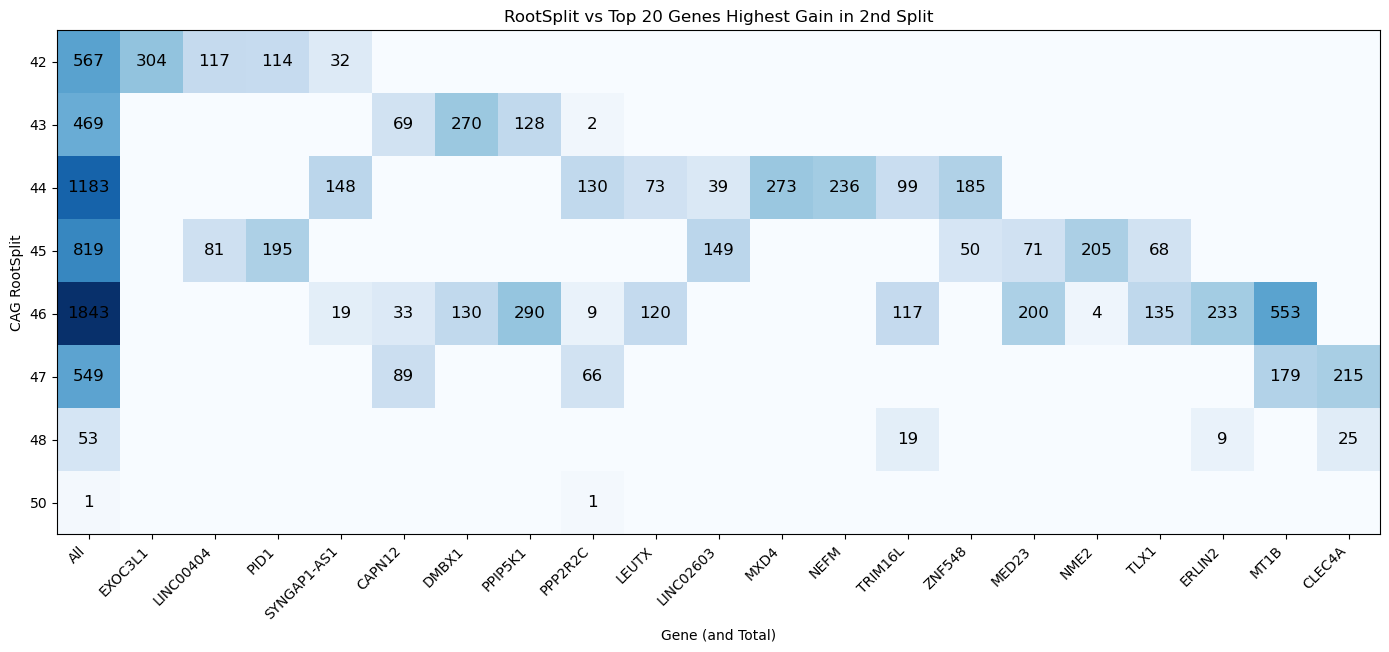

In [41]:
from matplotlib.colors import PowerNorm

# Load top features from global importance
top_genes = secondary_split_summary['SecondFeature'].value_counts().head(20).index

def rootcag_col_histogram(secondary_split_summary, top_genes):
    """
    Plot a heatmap where each column is a gene and the rows are different root CAG splits.
    The value in the cells corresponds to how many trees are using that gene as a 
    secondary split, having CAG at the root node with a particular split value.
    """
    filtered_df = secondary_split_summary[secondary_split_summary['SecondFeature'].isin(top_genes)]

    # Create pivot table: RootSplit as rows, Gene as columns
    pivot = pd.pivot_table(filtered_df, values='Tree', index='RootSplit', columns='SecondFeature', aggfunc='count', fill_value=0)

    # Histogram column: total counts per RootSplit (row-wise sum)
    pivot.insert(0, 'All', pivot.sum(axis=1))

    # Sort gene columns (excluding 'All') by lowest RootSplit they appear in
    def first_nonzero_index(col):
        return next((i for i, val in enumerate(col) if val > 0), float('inf'))

    gene_order = sorted([gene for gene in pivot.columns if gene != 'All'],
                        key=lambda gene: first_nonzero_index(pivot[gene].values))

    # Reinsert 'All' as the first column
    pivot = pivot[['All'] + gene_order]

    # Plot with matplotlib
    fig, ax = plt.subplots(figsize=(14, 8))
    # Apply logarithmic normalization to color scale
    im = ax.imshow(pivot.values, cmap='Blues', norm=PowerNorm(gamma=0.5))
    # Axis ticks and labels
    ax.set_xticks(np.arange(pivot.columns.shape[0]))
    ax.set_xticklabels(pivot.columns, rotation=45, ha="right")

    ax.set_yticks(np.arange(pivot.index.shape[0]))
    ax.set_yticklabels([int(r) for r in pivot.index])  # Ensure y-axis is integer labels

    # Annotate each cell with its value
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.iloc[i, j]
            if val > 0:
                ax.text(j, i, str(val), ha="center", va="center", color="black", fontsize=12)

    # Titles and labels
    ax.set_title("RootSplit vs Top 20 Genes Highest Gain in 2nd Split")
    ax.set_xlabel("Gene (and Total)")
    ax.set_ylabel("CAG RootSplit")

    fig.tight_layout()
    # plt.show()

    return fig, ax

# Now use the existing function to plot
fig, ax = rootcag_col_histogram(secondary_split_summary, top_genes)
fig.savefig(f"{rna_results_dir}figures/rootsplit_vs_2ndfeat_allexp.pdf", dpi=300)

In [42]:
all_results = []
tree_props = []

for seed in seeds:
    tree_file = f"{rna_results_dir}multimodal_ES_xgboost_{seed}_trees.csv"
    if not os.path.exists(tree_file):
        print(f"Missing trees for seed {seed}")
        continue

    trees = pd.read_csv(tree_file, sep="\t", index_col=0)
    f1_roots = trees[(trees['Node'] == 0) & (trees['Feature'] == 'f1')]

    n_trees = len(trees['Tree'].unique())
    n_f1cag_trees = len(f1_roots['Tree'].unique())
    tree_props.append({
        'Seed': seed,
        'N_trees': n_trees,
        'f1CAG_trees': n_f1cag_trees,
        'Proportion': round((n_f1cag_trees / n_trees * 100), 3)
    })

    for _, root in f1_roots.iterrows():
        tree_id = root['Tree']
        root_split = float(root['Split'])

        # Parse Yes and No nodes (subnode IDs)
        yes_node = int(str(root['Yes']).split('-')[-1])
        no_node = int(str(root['No']).split('-')[-1])

        subtree = trees[trees['Tree'] == tree_id]

        # Yes branch (Smaller)
        yes_subnode = subtree[subtree['Node'] == yes_node]
        if not yes_subnode.empty:
            yes_subnode = yes_subnode.iloc[0]
            second_feature = yes_subnode['Feature']
            if second_feature != 'Leaf':
                second_feature_num = int(second_feature[1:])
                gene = header[second_feature_num]
                all_results.append({
                    'Seed': seed,
                    'Tree': tree_id,
                    'Root_Split': int(unscale_cag(root_split)),
                    'Branch': 'Smaller',
                    'Subnode_ID': yes_node,
                    'Subnode_Feature': gene
                })

        # No branch (Larger)
        no_subnode = subtree[subtree['Node'] == no_node]
        if not no_subnode.empty:
            no_subnode = no_subnode.iloc[0]
            second_feature = no_subnode['Feature']
            if second_feature != 'Leaf':
                second_feature_num = int(second_feature[1:])
                gene = header[second_feature_num]
                all_results.append({
                    'Seed': seed,
                    'Tree': tree_id,
                    'Root_Split': int(unscale_cag(root_split)),
                    'Branch': 'Larger',
                    'Subnode_ID': no_node,
                    'Subnode_Feature': gene
                })

# Final DataFrame
secondary_split_info = pd.DataFrame(all_results)

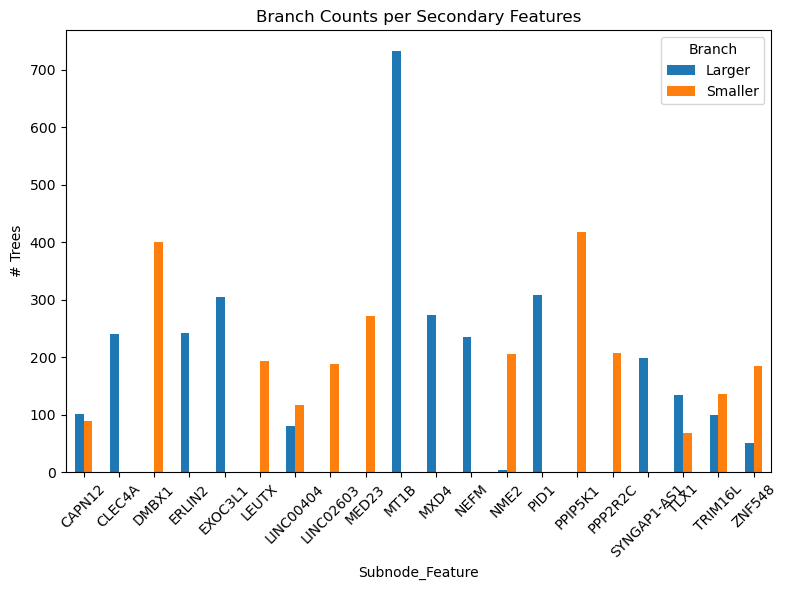

In [50]:
secondary_split_info = secondary_split_info[secondary_split_info['Subnode_Feature'].isin(top_genes)]

# Count Branch occurrences per Subnode_Feature
counts = secondary_split_info.groupby(['Subnode_Feature', 'Branch']).size().unstack(fill_value=0)

# Plot
counts.plot(kind='bar', figsize=(8, 6))
plt.ylabel('# Trees')
plt.title('Branch Counts per Secondary Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{rna_results_dir}figures/2ndfeat_allexp_direct.pdf", dpi=300)
plt.show()

In [54]:
# Store proportion of f1 CAG trees
tree_props = []

# Iterate through all valid seeds
for seed in seeds:
    tree_file = f"{rna_results_dir}multimodal_ES_xgboost_{seed}_trees.csv"
    if not os.path.exists(tree_file):
        print(f"Missing trees for seed {seed}")
        continue
    
    trees = pd.read_csv(tree_file, sep="\t", index_col=0)
    f1_roots = trees[(trees['Node'] == 0) & (trees['Feature'] == 'f1')]

    n_trees = len(trees['Tree'].unique())
    n_f1cag_trees = len(f1_roots['Tree'].unique())
    tree_props.append({'Seed':seed, 'N_trees': n_trees, 'f1CAG_trees': n_f1cag_trees, 'proportion': round((n_f1cag_trees/n_trees*100), 3)})

tree_props_df = pd.DataFrame(tree_props)

tree_props_df['proportion'].mean()

45.718545454545456